# Benchmarking and Profiling

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/fitter-happier-models/blob/master/docs/notebooks/hp/)
[![Stars](https://img.shields.io/github/stars/particle1331/fitter-happier-models?style=social)](https://github.com/particle1331/fitter-happier-models)

---

## Introduction

Recognizing the slow parts of your program is the single most important task when it
comes to speeding up your code. This is because in most cases, the code that causes the application to
slow down is a very small fraction of the program. By identifying these critical sections, you can focus on the parts that need the most improvement without wasting time in micro-optimization which lead to marginal speedups relative to parts where the most computation occurs. 

In this notebook, we will write a simulation of a collection of concentric particles in uniform circular motion. We will use two techniques **profiling** and **benchmarking**, as well as look at memory consumption which can be relevant when our program deals with large data. To make sure that any optimization does not break the core logic of our program, we will write **unit tests**. Our strategy is to start with a simple conceptual code that works which would allow us to write tests. This would allow us to start optimizing our code.

In [1]:
import math

# https://github.com/particle1331/fitter-happier-models/tree/master/docs/notebooks/hp/src
from src.particles import Particle, ParticleSimulator
from src.particles import visualize_simulation
from src.particles import benchmark, benchmark_memory, random_particles

# https://github.com/particle1331/fitter-happier-models/tree/master/docs/notebooks/hp/test
from test.test_particles import test_evolve

%load_ext autoreload
%autoreload 2

## Simulation

To write simulation code, we divide the code into **objects** and **physics**. The physics of the system determines the update rule for each episode as well as the configuration of the initial episode. Our objects will be particles defined in the `Particle` class. This just contains three variables for position and signed angular speed which determine the state of the particle.

```python
# https://github.com/particle1331/fitter-happier-models/tree/master/docs/notebooks/hp/src/particles.py

class Particle:
    def __init__(self, x, y, angular_vel):
        self.x = x
        self.y = y
        self.ω = angular_vel
```

The physics of the system is encoded in the `ParticleSimulator` and an initialization function for the particles. This takes in a list of particles as well as a constant `h` which is the increment for the Euler method. This can be interpreted as the quantum of time for the system. 

The simulator defines a method `evolve(t)` which incrementally updates the position of each particle from `t=0` to `t=t`. More precisely to `s=hn` for largest `n` such that `s≤t`. Note that same update rule is applied to all particles which makes sense by symmetry. Moreover, the rule is static in that it does not change over time. These two assumptions make up the `evolve` method. The exact update rule is defined in the `update_particle` method. For this simulation, we simply rotate all particles around the origin with a fixed radius based on its initial position and with an angular velocity that is given at initialization.

```python
# https://github.com/particle1331/fitter-happier-models/tree/master/docs/notebooks/hp/src/particles.py

class ParticleSimulator:
    def __init__(self, particles: list[Particle], h=1e-5):
        self.h = h  # Euler-method increment 
        self.particles = particles

    def evolve(self, t: float):
        """Evolve system from t=0 to t=t."""
        
        n_steps = int(t / self.h)
        for _ in range(n_steps):
            for p in self.particles:
                self.update_particle(p)

    def update_particle(self, p: Particle):
        """Evolve particle with Δt = h."""

        vx = -p.y * p.ω
        vy =  p.x * p.ω
        dx = vx * self.h
        dy = vy * self.h
        p.x += dx
        p.y += dy
```

**Example.** The following shows the time evolution of the system of three particles with the same angular speed, incremented by 1 time units for each frame.

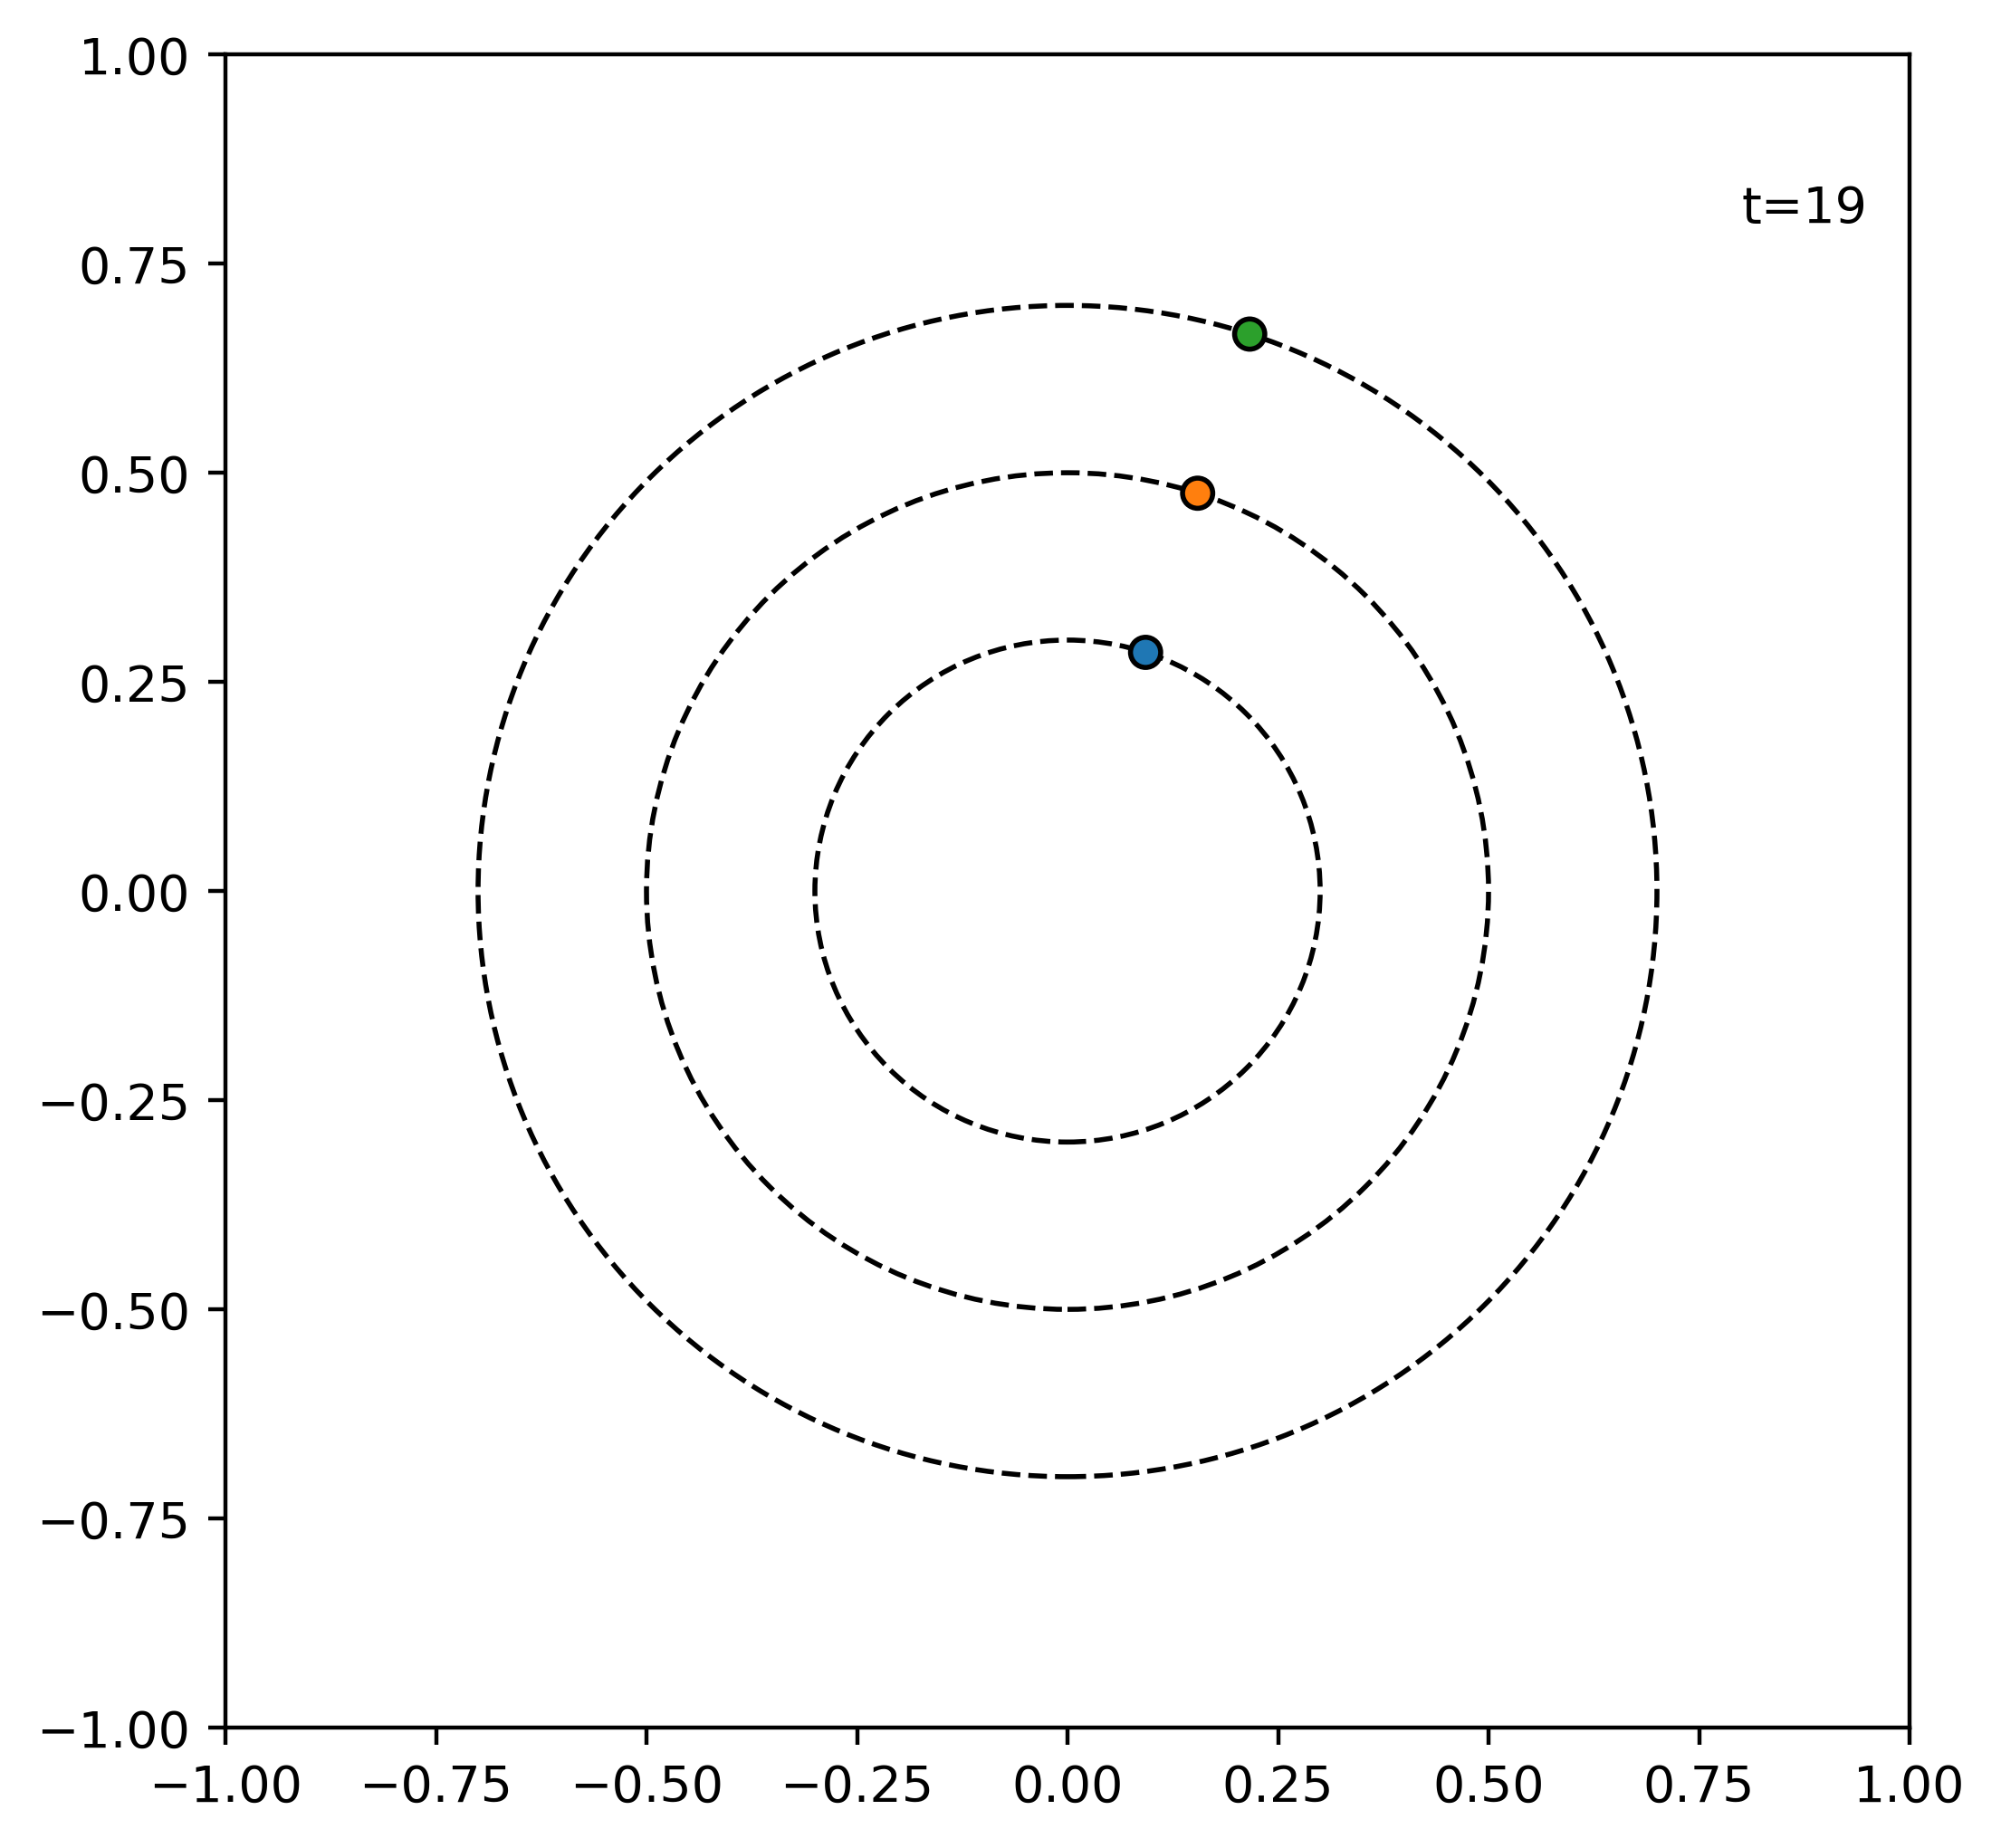

In [2]:
particles = [
    Particle(0.0, 0.3, 0.10 * math.pi),
    Particle(0.0, 0.5, 0.10 * math.pi),
    Particle(0.0, 0.7, 0.10 * math.pi)
]

simulator = ParticleSimulator(particles)
visualize_simulation(simulator, timesteps=20, fps=5) # fps = no. time steps per second => 4 second GIF

```{figure} particles.gif
---
width: 550px
---
```

For our tests, we consider the following three simple scenarios:

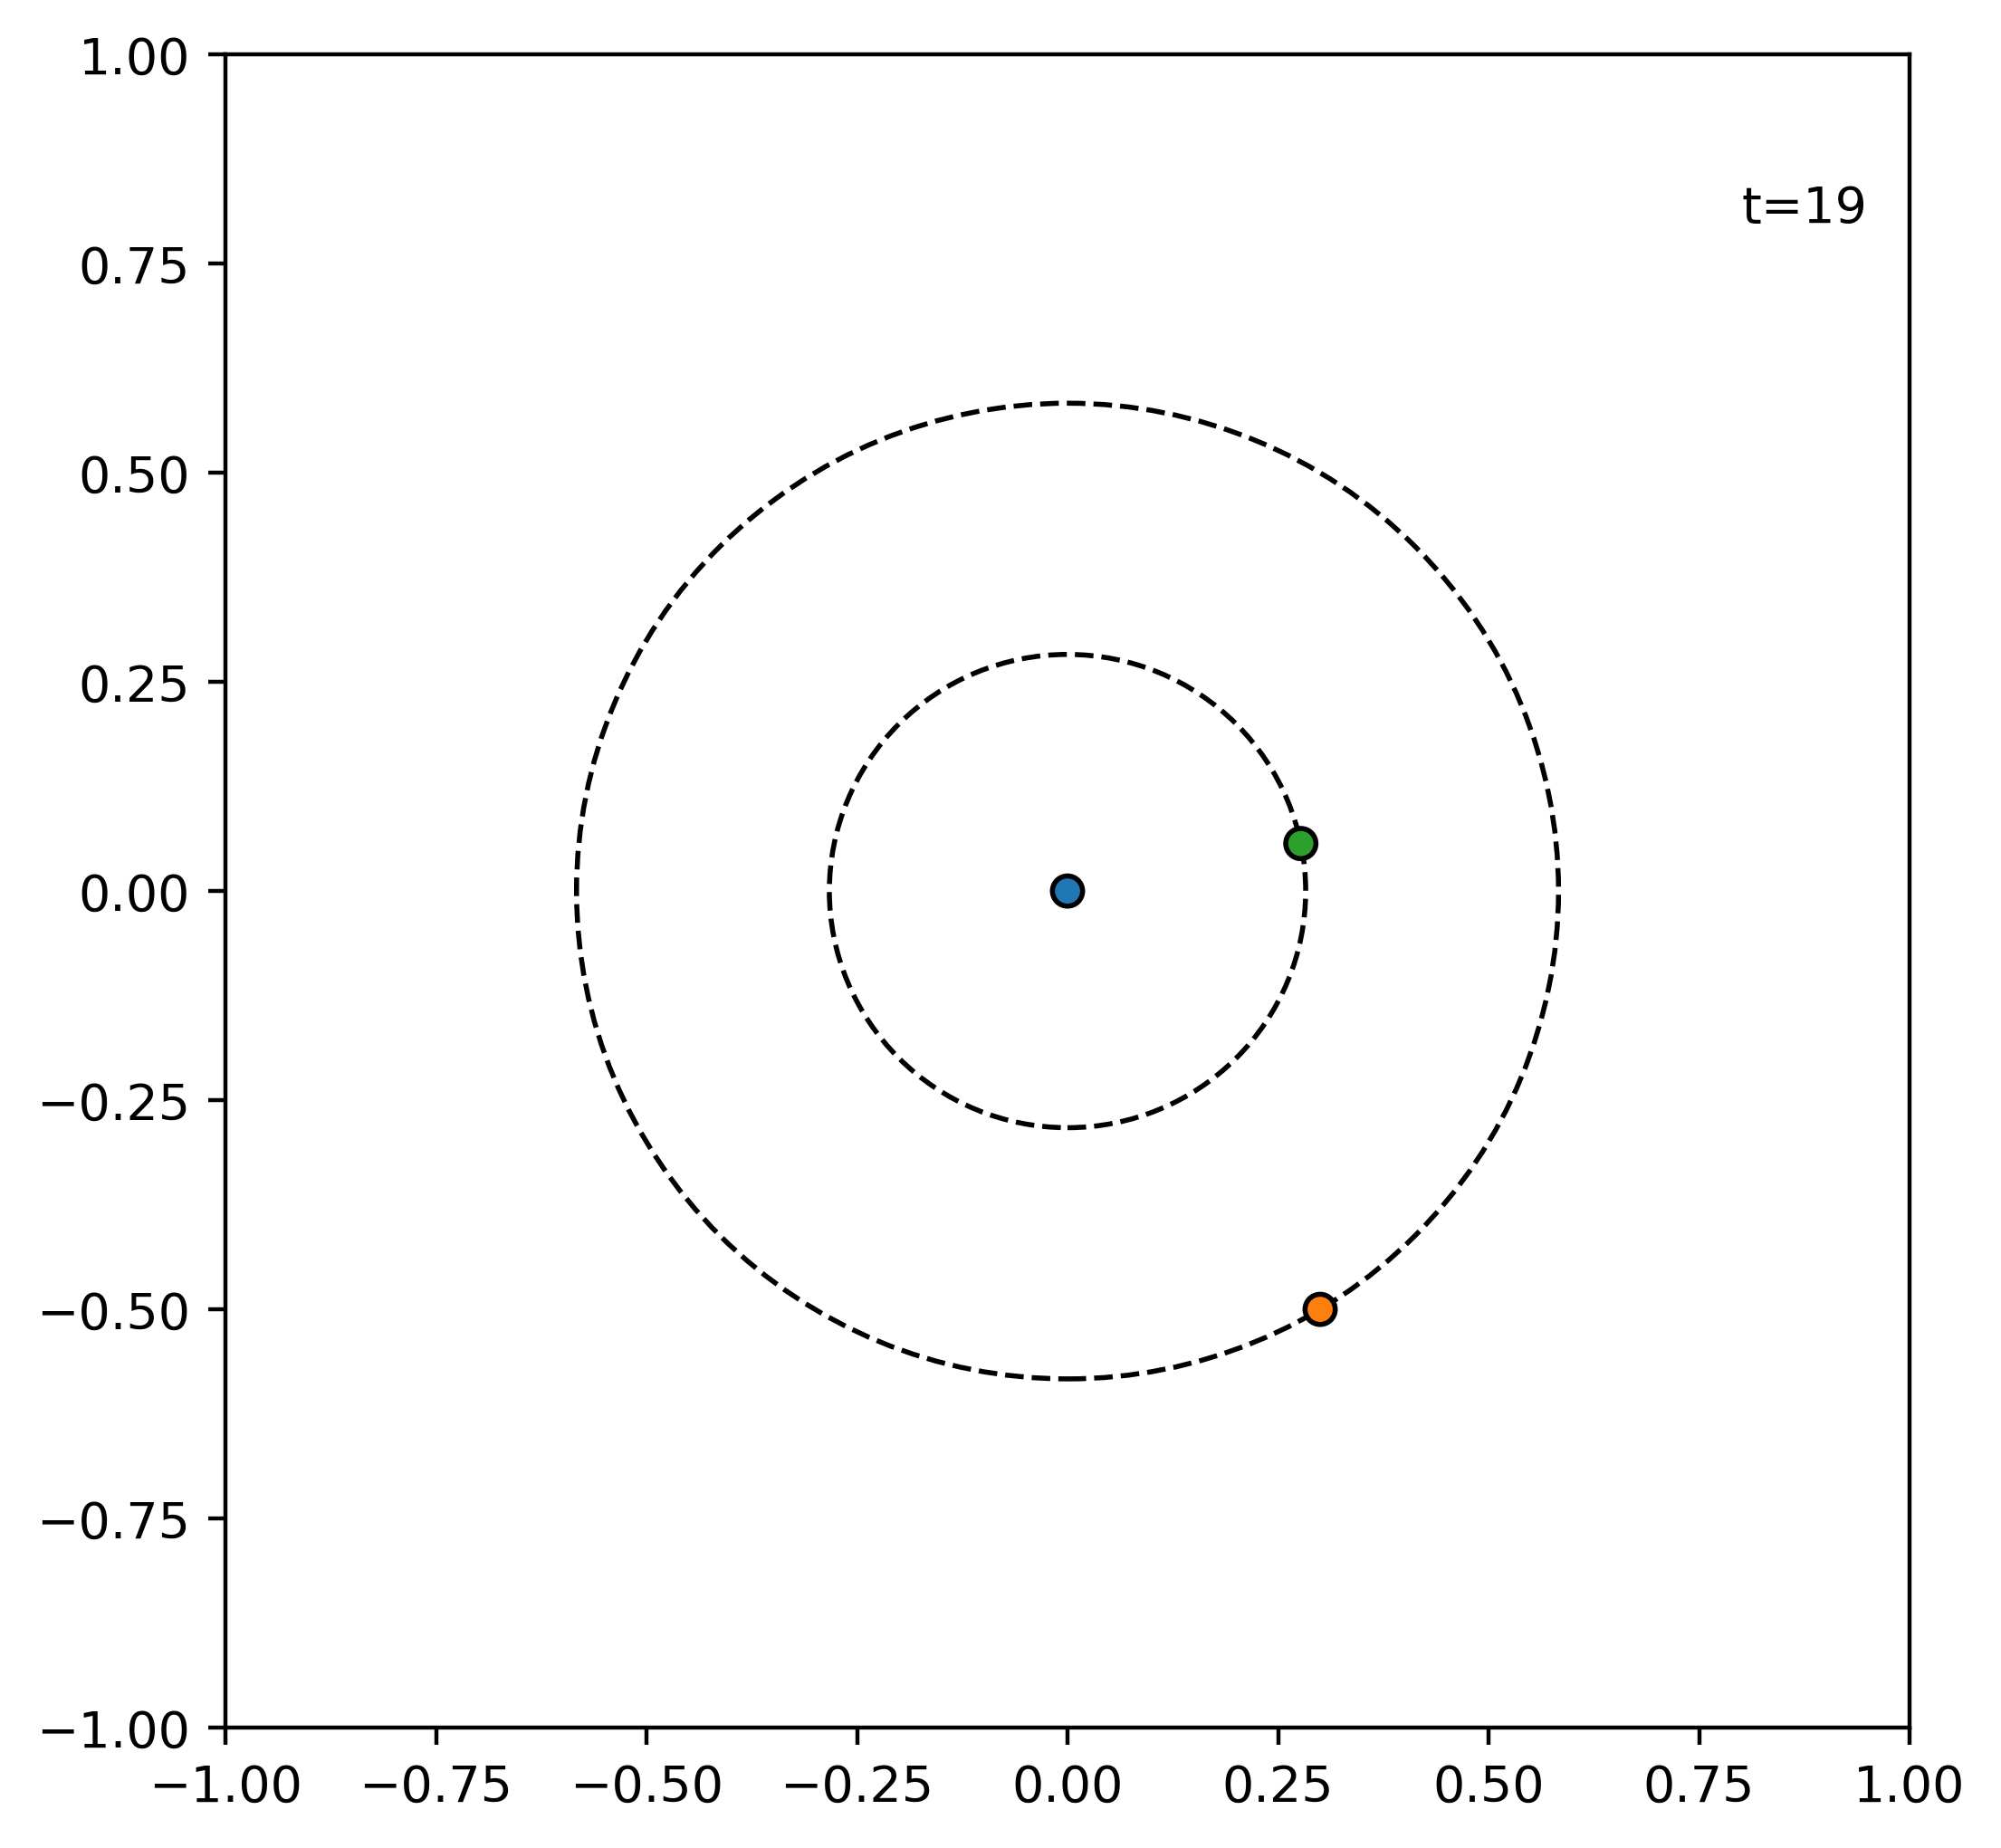

In [3]:
particles = [
    Particle( 0.0,  0.0, +1.0),
    Particle( 0.3, -0.5,  0.0),
    Particle(+0.2, +0.2, +0.3)
]

simulator = ParticleSimulator(particles)
visualize_simulation(simulator, timesteps=20, fps=5, savename='particles-test.gif') # fps = no. time steps per second => 4 second GIF

```{figure} particles-test.gif
---
width: 550px
---
```

## Tests and benchmarks

Tests ensure things still work when we refactor and optimize our code. In particular, we will write **unit tests** designed to verify the intended logic of the program regardless of the implementation details, which may change during optimization. We test the `evolve` function of the simulator on three simple cases which are easily mathematically tractable. An error tolerance of `1e-6` for a time evolution of `0.1` is used.

```python
# https://github.com/particle1331/fitter-happier-models/blob/dev/docs/notebooks/hp/test/test_particles.py

def test_evolve():
    particles = [
        Particle( 0.0,  0.0, +1.0),
        Particle( 0.3, -0.5,  0.0),
        Particle(+0.2, +0.2, +0.3)
    ]

    simulator = ParticleSimulator(particles)
    simulator.evolve(0.1)

    p0, p1, p2 = particles

    def fequal(a, b, eps=1e-6):
        return abs(a - b) < eps

    assert fequal(p0.x,  0.0)
    assert fequal(p0.y,  0.0)
    assert fequal(p1.x,  0.3)
    assert fequal(p1.y, -0.5)
    assert fequal(p2.x, (0.2 ** 2 + 0.2 ** 2) ** 0.5 * math.cos(math.pi / 4 + 0.1 * 0.3))
    assert fequal(p2.y, (0.2 ** 2 + 0.2 ** 2) ** 0.5 * math.sin(math.pi / 4 + 0.1 * 0.3))
```

Running `pytest`:

In [4]:
!pytest test -v -s

============================= test session starts ==============================
platform darwin -- Python 3.9.15, pytest-7.2.0, pluggy-1.0.0 -- /Users/particle1331/opt/miniconda3/envs/ai/bin/python3.9
cachedir: .pytest_cache
benchmark: 4.0.0 (defaults: timer=time.perf_counter disable_gc=False min_rounds=5 min_time=0.000005 max_time=1.0 calibration_precision=10 warmup=False warmup_iterations=100000)
rootdir: /Users/particle1331/code/fitter-happier-models/docs/notebooks/hp
plugins: anyio-3.6.2, benchmark-4.0.0
collected 1 item                                                               

test/test_particles.py::test_evolve PASSED

============================== 1 passed in 0.27s ===============================


### Benchmarking

Tests ensure the correctness of our functionality but gives little information about its
running time. A **benchmark** is a simple and representative use case that can be run to
assess the running time of an application. Benchmarks are very useful to keep score of
how fast our program is with each new version that we implement.

```python
# https://github.com/particle1331/fitter-happier-models/blob/dev/master/notebooks/hp/src/particles.py

def random_particles(n: int) -> list[Particle]:
    particles = []
    for _ in range(n):
        x, y, ω = np.random.random(3)
        particles.append(Particle(x, y, ω))
    return particles

def benchmark():
    particles = random_particles(100)
    simulator = ParticleSimulator(particles)
    simulator.evolve(1.0)
```

For an accurate measurement, the benchmark should be designed to have a long
enough execution time (in the order of seconds) so that the setup and teardown of the
process are small compared to the execution time of the application. Running the benchmark using [`timeit`](https://docs.python.org/3/library/timeit.html):

In [6]:
%timeit benchmark()

4.22 s ± 9.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Line profiling

Profiling functions line-by-line can be useful for precisely determining bottlenecks. Note that the `Time` column is based on the `Timer unit` set to `1e-06`. For example, the line that performs random sampling uses up `0.000169 s` execution time out of the total `0.000255 s`. 

In [7]:
%load_ext line_profiler
%lprun -f random_particles random_particles(100)

Timer unit: 1e-06 s

Total time: 0.000255 s
File: /Users/particle1331/code/fitter-happier-models/docs/notebooks/hp/src/particles.py
Function: random_particles at line 108

Line #      Hits         Time  Per Hit   % Time  Line Contents
   108                                           def random_particles(n: int) -> list[Particle]:
   109         1          1.0      1.0      0.4      particles = []
   110       101         19.0      0.2      7.5      for _ in range(n):
   111       100        169.0      1.7     66.3          x, y, ω = np.random.random(3)
   112       100         66.0      0.7     25.9          particles.append(Particle(x, y, ω))
   113         1          0.0      0.0      0.0      return particles

In [8]:
%lprun -f benchmark benchmark()

Timer unit: 1e-06 s

Total time: 10.4424 s
File: /Users/particle1331/code/fitter-happier-models/docs/notebooks/hp/src/particles.py
Function: benchmark at line 115

Line #      Hits         Time  Per Hit   % Time  Line Contents
   115                                           def benchmark():
   116         1        275.0    275.0      0.0      particles = random_particles(100)
   117         1          1.0      1.0      0.0      simulator = ParticleSimulator(particles)
   118         1   10442153.0 10442153.0    100.0      simulator.evolve(1.0)

Notice that most compute occurs in evolving the system. This makes sense. We will proceed to optimize this part of the code in the next section. Note that [`line_profiler`](https://github.com/pyutils/line_profiler) can be used in the command line using:

```bash
kernprof -l -v script.py
``` 

where the function to profile is decorated with `@profile`.

## Optimizing our code

Now that we know where the bottleneck to our code is, we can start optimizing this part of the code. To make our code faster, we use **vectorization** using the `numpy` library. This allows us to update the particles in parallel. Note that in the `evolve` method we replace looping on the particles with array operations on the data matrix which stores the data of all particles in the system. Using `np.float64` is also important to get precise enough for the tests.

```python
# https://github.com/particle1331/fitter-happier-models/blob/dev/docs/notebooks/hp/src/particles.py

class ParticleSimulator:
    def __init__(self, particles: list[Particle], h=1e-5):
        self.h = h  # Euler-method increment 
        self.particles = particles
        self.data = np.array([[p.x, p.y, p.ω] for p in particles], dtype=np.float64)

    def evolve(self, t: float):
        """Evolve system from t=0 to t=t."""

        n_steps = int(t / self.h)
        for _ in range(n_steps):
            self.update_data()

        for i, p in enumerate(self.particles):
            p.x, p.y = self.data[i, [0, 1]]

    def update_data(self):
        """Evolve particle with Δt = h."""

        x = self.data[:, [0]]
        y = self.data[:, [1]]
        ω = self.data[:, [2]]
        vx = -y * ω
        vy =  x * ω
        dx = vx * self.h
        dy = vy * self.h
        self.data[:, [0]] += dx
        self.data[:, [1]] += dy
```

Running the test and benchmarks with the optimized code:

In [9]:
!pytest test -v -s

============================= test session starts ==============================
platform darwin -- Python 3.9.15, pytest-7.2.0, pluggy-1.0.0 -- /Users/particle1331/opt/miniconda3/envs/ai/bin/python3.9
cachedir: .pytest_cache
benchmark: 4.0.0 (defaults: timer=time.perf_counter disable_gc=False min_rounds=5 min_time=0.000005 max_time=1.0 calibration_precision=10 warmup=False warmup_iterations=100000)
rootdir: /Users/particle1331/code/fitter-happier-models/docs/notebooks/hp
plugins: anyio-3.6.2, benchmark-4.0.0
collected 1 item                                                               

test/test_particles.py::test_evolve PASSED

============================== 1 passed in 0.39s ===============================


In [10]:
%timeit benchmark()

1.11 s ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%lprun -f benchmark benchmark()

Timer unit: 1e-06 s

Total time: 1.24545 s
File: /Users/particle1331/code/fitter-happier-models/docs/notebooks/hp/src/particles.py
Function: benchmark at line 115

Line #      Hits         Time  Per Hit   % Time  Line Contents
   115                                           def benchmark():
   116         1        265.0    265.0      0.0      particles = random_particles(100)
   117         1         54.0     54.0      0.0      simulator = ParticleSimulator(particles)
   118         1    1245132.0 1245132.0    100.0      simulator.evolve(1.0)

Note that the execution time has been reduced by one order of magnitude!

## Memory profiling

Memory profiling can be useful for data intensive tasks. This can determine inefficiencies with data structures used as well as algorithms used for processing data. As benchmark, we simply increase the number of particles in the simulation:

```python
# https://github.com/particle1331/fitter-happier-models/blob/dev/docs/notebooks/hp/src/particles.py

def benchmark_memory():
    particles = random_particles(1000000)
    simulator = ParticleSimulator(particles)
    simulator.evolve(0.001)
```

The `Increment` column shows how much each line affects the total memory consumption while `Mem usage` is the cumulative memory use of the function. Note that the function starts out with some background memory consumption from the interpreter and profiler. This has to be roughly equal for benchmark results to be comparable.

In [2]:
%load_ext memory_profiler
%mprun -f benchmark_memory benchmark_memory()

Filename: /Users/particle1331/code/fitter-happier-models/docs/notebooks/hp/src/particles.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   120     91.6 MiB     91.6 MiB           1   def benchmark_memory():
   121    353.9 MiB    262.4 MiB           1       particles = random_particles(1000000)
   122    370.0 MiB     16.0 MiB           1       simulator = ParticleSimulator(particles)
   123    317.7 MiB    -52.3 MiB           1       simulator.evolve(0.001)

```{margin}
**1 MiB** = 1,048,576 bytes
```

This indicates that 1,000,000 `Particle` objects take around 260 MiB of memory.
To reduce each particles memory footprint, we can use `__slots__` on the `Particle` class. 
This saves some memory by avoiding storing the variables of the instance in an internal
dictionary with the small limitation that the addition of
attributes other than the ones specified is not allowed.

```python
class Particle:
    __slots__ = ('x', 'y', 'ω') 

    def __init__(self, x, y, angular_vel):
        self.x = x
        self.y = y
        self.ω = angular_vel
```

Running the profiler:

In [3]:
%mprun -f benchmark_memory benchmark_memory()

Filename: /Users/particle1331/code/fitter-happier-models/docs/notebooks/hp/src/particles.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   120     86.9 MiB     86.9 MiB           1   def benchmark_memory():
   121    261.3 MiB    174.4 MiB           1       particles = random_particles(1000000)
   122    294.8 MiB     33.4 MiB           1       simulator = ParticleSimulator(particles)
   123    357.6 MiB     62.8 MiB           1       simulator.evolve(0.001)

Using slots resulted in a reduction from ~260 MiB to ~170 MiB. Note that [`memory_profiler`](https://github.com/pythonprofilers/memory_profiler) has a command-line interface:

```
mprof run <script.py>
mprof plot
```

This expects a Python script that defines a function of interest decorated with `@profile` imported from the `memory_profiler` module. It should also execute the function, so that the memory profiler tracks something. ■